<a href="https://colab.research.google.com/github/gui-93/House-Price-Prediction/blob/main/modelo_precos_casas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Modelo de Regressão para Previsão de Preços de Casas

Este notebook mostra passo a passo como treinar diferentes modelos de regressão para prever preços de casas:
- **Regressão Linear**
- **Random Forest**
- **XGBoost**

No final, comparamos os erros de cada modelo e visualizamos os resultados em gráfico.

In [2]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [3]:
#  Carregar os dados
dados = pd.read_csv('/content/train.csv')
print(f"Dataset shape: {dados.shape}")
print(f"Target: SalePrice")
print("\nPrimeiras 5 linhas:")
print(dados.head())

Dataset shape: (1460, 81)
Target: SalePrice

Primeiras 5 linhas:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  Y

In [4]:
# Informações básicas do dataset
print(f"\nEstatísticas da variável target (SalePrice):")
print(dados['SalePrice'].describe())



Estatísticas da variável target (SalePrice):
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [5]:
# Verificar valores missing
missing_data = dados.isnull().sum()
missing_percent = 100 * missing_data / len(dados)
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Percentage', ascending=False)

print(f"\nColunas com valores missing (>0%):")
print(missing_df[missing_df['Missing Percentage'] > 0].head(10))


Colunas com valores missing (>0%):
              Missing Count  Missing Percentage
PoolQC                 1453           99.520548
MiscFeature            1406           96.301370
Alley                  1369           93.767123
Fence                  1179           80.753425
MasVnrType              872           59.726027
FireplaceQu             690           47.260274
LotFrontage             259           17.739726
GarageQual               81            5.547945
GarageFinish             81            5.547945
GarageType               81            5.547945


In [6]:
# Selecionar features mais importantes para o modelo
# Baseado no dataset, vamos usar as features mais relevantes
features_numericas = [
    'LotArea',        # Área do terreno
    'OverallQual',    # Qualidade geral da casa
    'OverallCond',    # Condição geral da casa
    'YearBuilt',      # Ano de construção
    'YearRemodAdd',   # Ano da reforma
    'TotalBsmtSF',    # Área total do porão
    '1stFlrSF',       # Área do 1º andar
    '2ndFlrSF',       # Área do 2º andar
    'GrLivArea',      # Área de estar
    'FullBath',       # Banheiros completos
    'HalfBath',       # Lavabos
    'BedroomAbvGr',   # Quartos acima do solo
    'KitchenAbvGr',   # Cozinhas acima do solo
    'TotRmsAbvGrd',   # Total de cômodos acima do solo
    'Fireplaces',     # Lareiras
    'GarageCars',     # Vagas na garagem
    'GarageArea',     # Área da garagem
    'WoodDeckSF',     # Área do deck de madeira
    'OpenPorchSF',    # Área da varanda aberta
]

features_categoricas = [
    'MSZoning',       # Zoneamento
    'Neighborhood',   # Bairro
    'HouseStyle',     # Estilo da casa
    'ExterQual',      # Qualidade exterior
    'ExterCond',      # Condição exterior
    'Foundation',     # Fundação
    'HeatingQC',      # Qualidade do aquecimento
    'CentralAir',     # Ar condicionado central
    'KitchenQual',    # Qualidade da cozinha
    'GarageType',     # Tipo de garagem
]

**Escolhemos features que logicamente influenciam o preço. Com 81 colunas originais, focar nas mais relevantes melhora performance e interpretabilidade**

In [7]:
# Criar dataset com features selecionadas
features_selecionadas = features_numericas + features_categoricas
dados_modelo = dados[features_selecionadas + ['SalePrice']].copy()

print(f"\nFeatures selecionadas: {len(features_selecionadas)}")
print(f"Dados para modelo: {dados_modelo.shape}")



Features selecionadas: 29
Dados para modelo: (1460, 30)


In [8]:
# Tratar valores missing
print("\nTratando valores missing...")

# Para features numéricas: preencher com mediana
for col in features_numericas:
    if col in dados_modelo.columns:
        dados_modelo[col].fillna(dados_modelo[col].median(), inplace=True)

# Para features categóricas: preencher com 'Unknown'
for col in features_categoricas:
    if col in dados_modelo.columns:
        dados_modelo[col].fillna('Unknown', inplace=True)

# Encoding de variáveis categóricas
print("\nFazendo encoding das variáveis categóricas...")

label_encoders = {}
for col in features_categoricas:
    if col in dados_modelo.columns:
        le = LabelEncoder()
        dados_modelo[col] = le.fit_transform(dados_modelo[col].astype(str))
        label_encoders[col] = le

# Verificar se ainda há missing values
print(f"\nMissing values após limpeza: {dados_modelo.isnull().sum().sum()}")


Tratando valores missing...

Fazendo encoding das variáveis categóricas...

Missing values após limpeza: 0


**Preservamos todas as observações, evitando perda de dados valiosos**

In [9]:
# Definir variáveis preditoras (X) e target (y)
X = dados_modelo.drop('SalePrice', axis=1)
y = dados_modelo['SalePrice']

print(f"\nFeatures (X): {X.shape}")
print(f"Target (y): {y.shape}")


Features (X): (1460, 29)
Target (y): (1460,)


In [10]:
# Normalizar os dados
print("\nNormalizando os dados...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Treino: {X_treino.shape}")
print(f"Teste: {X_teste.shape}")


Normalizando os dados...
Treino: (1168, 29)
Teste: (292, 29)


In [11]:
# MODELO 1: Regressão Linear
print("\nTreinando Regressão Linear...")
modelo_lr = LinearRegression()
modelo_lr.fit(X_treino, y_treino)
y_pred_lr = modelo_lr.predict(X_teste)

# Métricas Regressão Linear
mae_lr = mean_absolute_error(y_teste, y_pred_lr)
mse_lr = mean_squared_error(y_teste, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_teste, y_pred_lr)

print(f"Regressão Linear - MAE: ${mae_lr:,.2f}")
print(f"Regressão Linear - RMSE: ${rmse_lr:,.2f}")
print(f"Regressão Linear - R²: {r2_lr:.4f}")


Treinando Regressão Linear...
Regressão Linear - MAE: $22,083.62
Regressão Linear - RMSE: $35,647.28
Regressão Linear - R²: 0.8343


In [12]:
# MODELO 2: Random Forest
print("\nTreinando Random Forest...")
modelo_rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5
)
modelo_rf.fit(X_treino, y_treino)
y_pred_rf = modelo_rf.predict(X_teste)

# Métricas Random Forest
mae_rf = mean_absolute_error(y_teste, y_pred_rf)
mse_rf = mean_squared_error(y_teste, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_teste, y_pred_rf)

print(f"Random Forest - MAE: ${mae_rf:,.2f}")
print(f"Random Forest - RMSE: ${rmse_rf:,.2f}")
print(f"Random Forest - R²: {r2_rf:.4f}")


Treinando Random Forest...
Random Forest - MAE: $18,210.03
Random Forest - RMSE: $28,809.59
Random Forest - R²: 0.8918


In [13]:
# MODELO 3: XGBoost
print("\nTreinando XGBoost...")
modelo_xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    subsample=0.8
)
modelo_xgb.fit(X_treino, y_treino)
y_pred_xgb = modelo_xgb.predict(X_teste)

# Métricas XGBoost
mae_xgb = mean_absolute_error(y_teste, y_pred_xgb)
mse_xgb = mean_squared_error(y_teste, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_teste, y_pred_xgb)

print(f"XGBoost - MAE: ${mae_xgb:,.2f}")
print(f"XGBoost - RMSE: ${rmse_xgb:,.2f}")
print(f"XGBoost - R²: {r2_xgb:.4f}")



Treinando XGBoost...
XGBoost - MAE: $17,634.97
XGBoost - RMSE: $28,190.31
XGBoost - R²: 0.8964


In [14]:
# COMPARAÇÃO FINAL DOS MODELOS
print("\n" + "="*60)
print("RESUMO COMPARATIVO DOS MODELOS")
print("="*60)

resultados = pd.DataFrame({
    'Modelo': ['Regressão Linear', 'Random Forest', 'XGBoost'],
    'MAE': [mae_lr, mae_rf, mae_xgb],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb],
    'R²': [r2_lr, r2_rf, r2_xgb]
})

print(resultados.round(2))


RESUMO COMPARATIVO DOS MODELOS
             Modelo       MAE      RMSE    R²
0  Regressão Linear  22083.62  35647.28  0.83
1     Random Forest  18210.03  28809.59  0.89
2           XGBoost  17634.97  28190.31  0.90


In [15]:
# Encontrar o melhor modelo
melhor_modelo = resultados.loc[resultados['R²'].idxmax(), 'Modelo']
print(f"\nMELHOR MODELO: {melhor_modelo}")


MELHOR MODELO: XGBoost


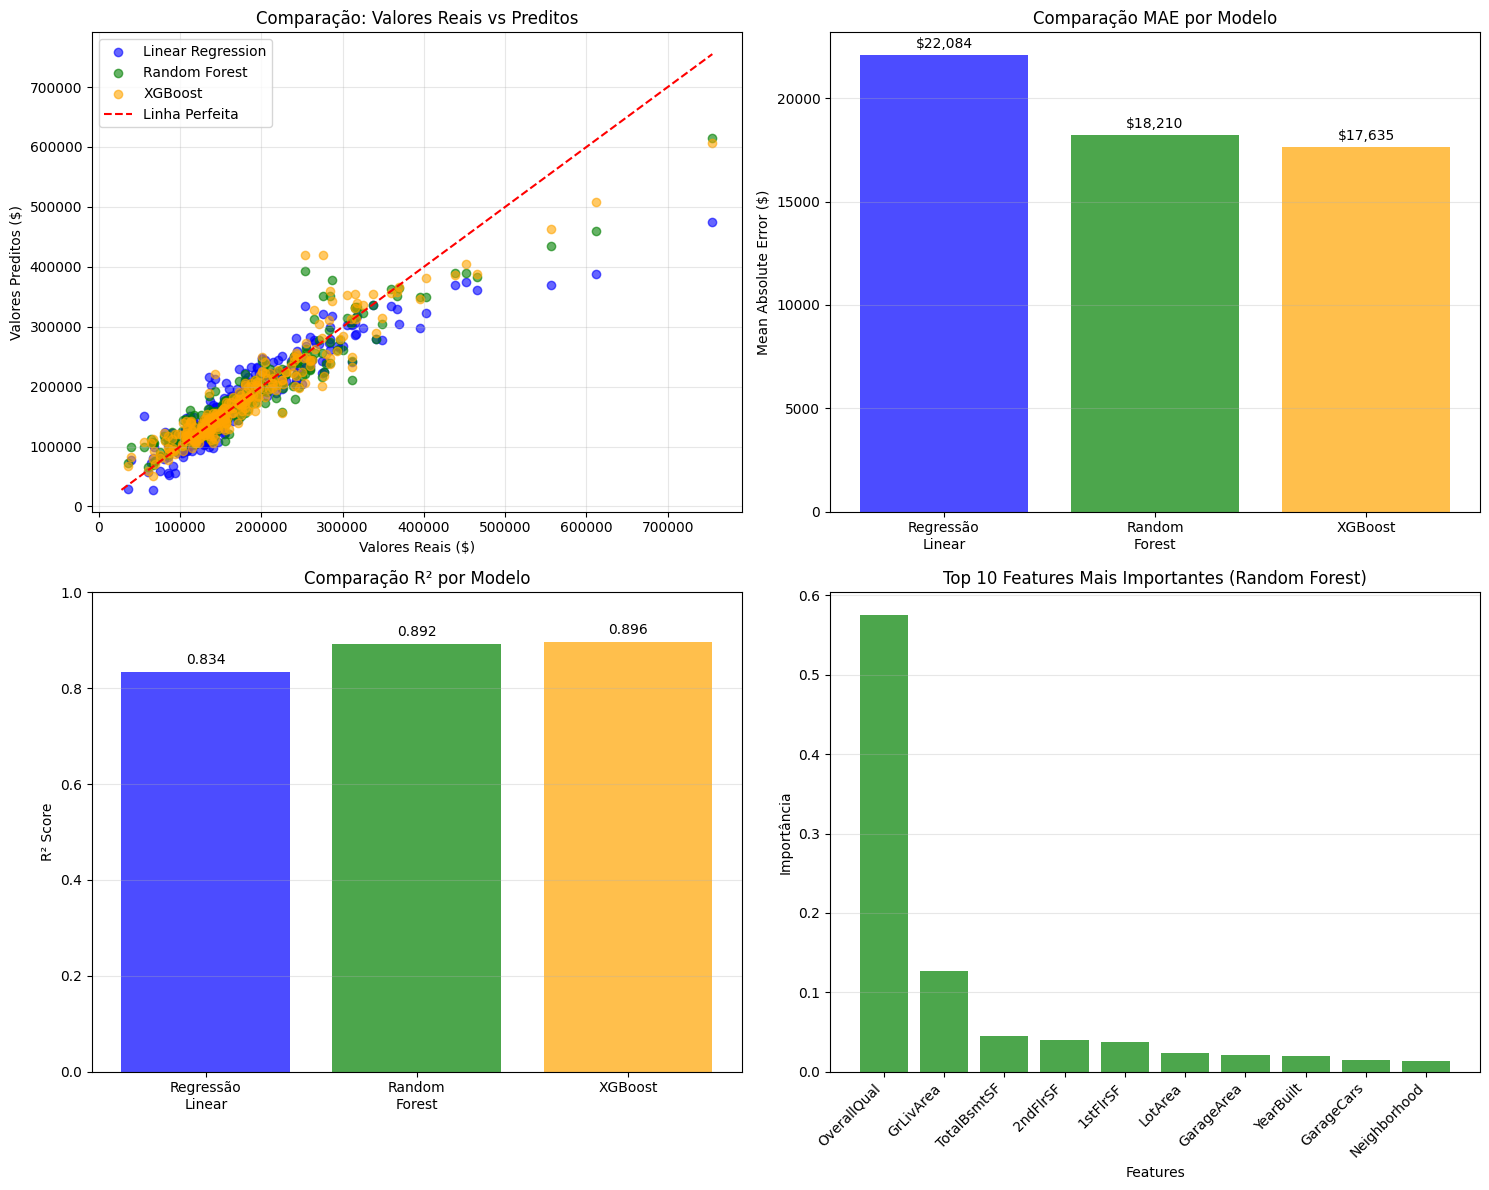

In [16]:
# VISUALIZAÇÕES
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scatter plot - Valores Reais vs Preditos
axes[0, 0].scatter(y_teste, y_pred_lr, alpha=0.6, color='blue', label='Linear Regression')
axes[0, 0].scatter(y_teste, y_pred_rf, alpha=0.6, color='green', label='Random Forest')
axes[0, 0].scatter(y_teste, y_pred_xgb, alpha=0.6, color='orange', label='XGBoost')

min_val = min(y_teste.min(), y_pred_lr.min(), y_pred_rf.min(), y_pred_xgb.min())
max_val = max(y_teste.max(), y_pred_lr.max(), y_pred_rf.max(), y_pred_xgb.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Linha Perfeita')

axes[0, 0].set_xlabel('Valores Reais ($)')
axes[0, 0].set_ylabel('Valores Preditos ($)')
axes[0, 0].set_title('Comparação: Valores Reais vs Preditos')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Comparação de Métricas - MAE
modelos = ['Regressão\nLinear', 'Random\nForest', 'XGBoost']
maes = [mae_lr, mae_rf, mae_xgb]
colors = ['blue', 'green', 'orange']

bars = axes[0, 1].bar(modelos, maes, color=colors, alpha=0.7)
axes[0, 1].set_ylabel('Mean Absolute Error ($)')
axes[0, 1].set_title('Comparação MAE por Modelo')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for bar, mae in zip(bars, maes):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'${mae:,.0f}', ha='center', va='bottom')

# 3. Comparação R² Score
r2_scores = [r2_lr, r2_rf, r2_xgb]
bars2 = axes[1, 0].bar(modelos, r2_scores, color=colors, alpha=0.7)
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('Comparação R² por Modelo')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for bar, r2 in zip(bars2, r2_scores):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{r2:.3f}', ha='center', va='bottom')

# 4. Feature Importance (Random Forest)
importances = modelo_rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1][:10]  # Top 10

axes[1, 1].bar(range(10), importances[indices], color='green', alpha=0.7)
axes[1, 1].set_xlabel('Features')
axes[1, 1].set_ylabel('Importância')
axes[1, 1].set_title('Top 10 Features Mais Importantes (Random Forest)')
axes[1, 1].set_xticks(range(10))
axes[1, 1].set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

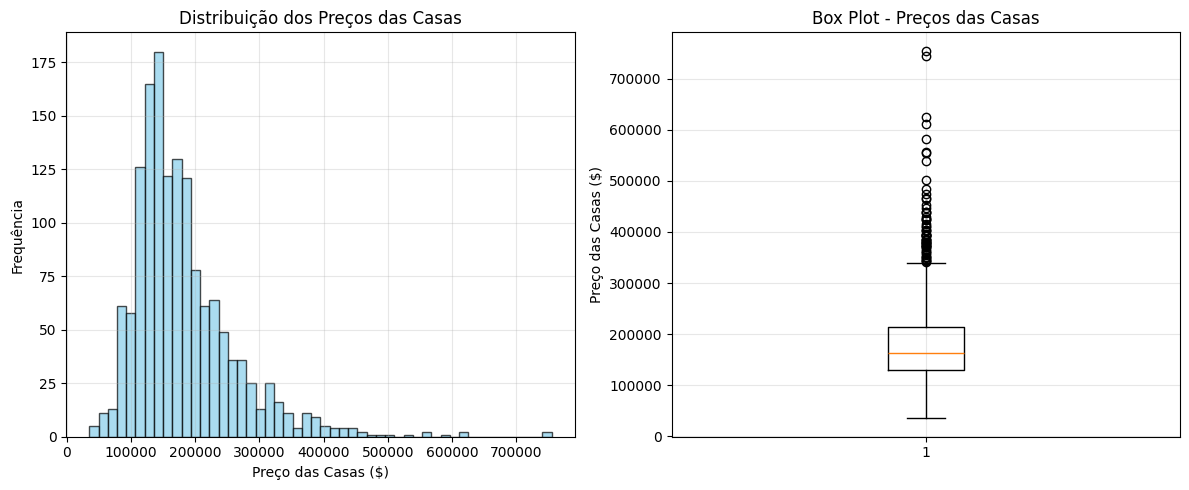


ANÁLISE COMPLETA FINALIZADA!
O modelo XGBoost apresentou o melhor desempenho!


In [17]:
# Gráfico de distribuição dos preços
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Preço das Casas ($)')
plt.ylabel('Frequência')
plt.title('Distribuição dos Preços das Casas')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(y)
plt.ylabel('Preço das Casas ($)')
plt.title('Box Plot - Preços das Casas')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nANÁLISE COMPLETA FINALIZADA!")
print(f"O modelo {melhor_modelo} apresentou o melhor desempenho!")